In [1]:
import imageio
import matplotlib.pyplot as plt
from mlxtend.image import extract_face_landmarks
import cv2
from dataset import CustomDataSetEvaluation

In [3]:
val_dataset = CustomDataSetEvaluation()

In [4]:
len(val_dataset)

49115

In [6]:
from train_autoencoder import ConvAutoencoder
import torch


net = ConvAutoencoder()
net = net.to("cuda")
state_dict = torch.load("./augmentor.pt")
net.load_state_dict(state_dict)
net.eval()

ConvAutoencoder(
  (decoder_emb_generator): EmbeddingGeneratorDecoder_VIT(
    (vit): VisionTransformer(
      (input_layer): Linear(in_features=64, out_features=512, bias=True)
      (transformer): Sequential(
        (0): AttentionBlock(
          (layer_norm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (linear): Sequential(
            (0): Linear(in_features=512, out_features=256, bias=True)
            (1): GELU()
            (2): Dropout(p=0.4, inplace=False)
            (3): Linear(in_features=256, out_features=512, bias=True)
            (4): Dropout(p=0.4, inplace=False)
          )
        )
        (1): AttentionBlock(
          (layer_norm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (attn): Multihead

# Experiment 1: Visualize AE reconstructions

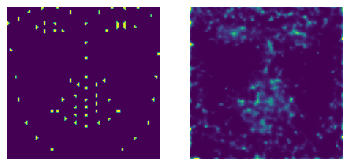

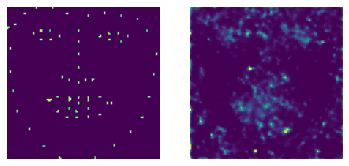

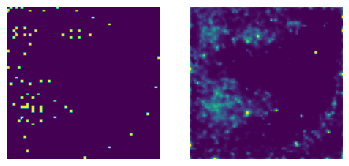

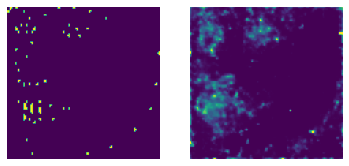

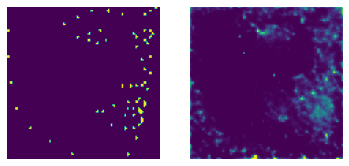

In [8]:
import numpy as np


with torch.no_grad():
    for i in np.random.randint(0, len(val_dataset), 5):
        data = val_dataset[i]
        
        pose_img = data[0]
        pose_img = torch.tensor(pose_img)
        pose_img = pose_img.unsqueeze(0)
        pose_img = pose_img.permute(0, 3, 1, 2)
        pose_img = pose_img.to("cuda").to(torch.float32)
        
        input_emb = data[1]
        input_emb = torch.tensor(input_emb)
        input_emb = input_emb.unsqueeze(0)
        input_emb = input_emb.to("cuda").to(torch.float32)
        
        output_emb = data[2]
        output_emb = torch.tensor(output_emb)
        output_emb = output_emb.unsqueeze(0)
        output_emb = output_emb.to("cuda").to(torch.float32)
        
        features = net.encoder(pose_img)
        reconstructed_data = net.decoder_pose_reconstructor(features)
        
        reconstructed_data = reconstructed_data.permute(0, 2, 3, 1).cpu().numpy()
        orig_data = pose_img.permute(0, 2, 3, 1).cpu().numpy()
        
        plt.subplot(1, 2, 1)
        plt.imshow(orig_data[0, :, :, 0])
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed_data[0, :, :, 0])
        plt.axis('off')
        plt.show()

# Experiment 2: Evaluate quality of generated representations

In [7]:
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.preprocessing import StandardScaler


objective1_traindata_embs = []
objective1_traindata_labels_pose = []
objective1_traindata_labels_id = []
objective1_traindata_labels_emo = []
objective1_valdata_embs = []
objective1_valdata_labels_pose = []
objective1_valdata_labels_id = []
objective1_valdata_labels_emo = []

objective2_traindata_embs = []
objective2_traindata_labels_pose = []
objective2_traindata_labels_id = []
objective2_traindata_labels_emo = []
objective2_valdata_embs = []
objective2_valdata_labels_pose = []
objective2_valdata_labels_id = []
objective2_valdata_labels_emo = []

objective3_traindata_embs = []
objective3_traindata_labels_pose = []
objective3_traindata_labels_id = []
objective3_traindata_labels_emo = []
objective3_valdata_embs = []
objective3_valdata_labels_pose = []
objective3_valdata_labels_id = []
objective3_valdata_labels_emo = []

for data in tqdm.tqdm(val_dataset):
    pose_img = data[0]
    pose_img = torch.Tensor(pose_img)
    pose_img = pose_img.unsqueeze(0)
    pose_img = pose_img.permute(0, 3, 1, 2)
    pose_img = pose_img.to("cuda").to(torch.float32)
    
    input_emb = data[1]
    objective1_traindata_embs.append(input_emb)
    objective2_traindata_embs.append(input_emb)
    objective3_traindata_embs.append(input_emb)
    input_emb = torch.Tensor(input_emb)
    input_emb = input_emb.unsqueeze(0)
    input_emb = input_emb.to("cuda").to(torch.float32)
    
    output_emb = data[2]
    output_emb = torch.Tensor(output_emb)
    output_emb = output_emb.unsqueeze(0)
    output_emb = output_emb.to("cuda").to(torch.float32)
    
    expected_pose_label = data[3]
    input_pose_label = data[4]
    objective1_traindata_labels_pose.append(input_pose_label)
    objective2_traindata_labels_pose.append(input_pose_label)
    objective3_traindata_labels_pose.append(input_pose_label)
    
    expected_id_label = data[5]
    objective1_traindata_labels_id.append(expected_id_label)
    objective2_traindata_labels_id.append(expected_id_label)
    objective3_traindata_labels_id.append(expected_id_label)
    
    expected_emo_label = data[6]
    objective1_traindata_labels_emo.append(expected_emo_label)
    objective2_traindata_labels_emo.append(expected_emo_label)
    objective3_traindata_labels_emo.append(expected_emo_label)
    
    # ensure to not mixing the train and validation sets
    output_emb = output_emb.detach().cpu().numpy()
    
    features = net.encoder(pose_img)
    generated_embedding = net.decoder_emb_generator(features, input_emb)
    
    generated_embedding = generated_embedding.detach().cpu().numpy()
    
    # objective 1: measuring how linear separable are the representations
    objective1_valdata_embs.append(generated_embedding[0]) 
    objective1_valdata_labels_pose.append(expected_pose_label) 
    objective1_valdata_labels_id.append(expected_id_label) 
    objective1_valdata_labels_emo.append(expected_emo_label)
    
    # objective 2 and 3: measuring how good the generated representations improve our accuracy
    objective2_valdata_embs.append(output_emb[0])
    objective2_valdata_labels_pose.append(expected_pose_label)
    objective2_valdata_labels_id.append(expected_id_label)
    objective2_valdata_labels_emo.append(expected_emo_label)
    
    objective3_traindata_embs.append(generated_embedding[0])
    objective3_traindata_labels_pose.append(expected_pose_label)
    objective3_traindata_labels_id.append(expected_id_label)
    objective3_traindata_labels_emo.append(expected_emo_label)
    
    objective3_valdata_embs.append(output_emb[0])
    objective3_valdata_labels_pose.append(expected_pose_label)
    objective3_valdata_labels_id.append(expected_id_label)
    objective3_valdata_labels_emo.append(expected_emo_label)

100%|██████████| 30001/30001 [56:49<00:00,  8.80it/s]  


In [8]:
print("objective1_traindata_labels_pose", np.unique(objective1_traindata_labels_pose, return_counts=True))
print("objective1_traindata_labels_id", np.unique(objective1_traindata_labels_id, return_counts=True))
print("objective1_traindata_labels_emo", np.unique(objective1_traindata_labels_emo, return_counts=True))

print("objective1_valdata_labels_pose", np.unique(objective1_valdata_labels_pose, return_counts=True))
print("objective1_valdata_labels_id", np.unique(objective1_valdata_labels_id, return_counts=True))
print("objective1_valdata_labels_emo", np.unique(objective1_valdata_labels_emo, return_counts=True))

objective1_traindata_labels_pose (array([0, 1, 2, 3, 4]), array([ 154,  260, 9771, 9908, 9908]))
objective1_traindata_labels_id (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]), array([1068, 1123, 1068, 1068, 1068, 1068, 1068,  986, 1068, 1068, 1288,
       1068,  986, 1068, 1068, 1068, 1068, 1068,  982, 1068, 1068, 1068,
       1068, 1068, 1068, 1124,  986, 1166]))
objective1_traindata_labels_emo (array([0, 1, 2, 3, 4, 5, 6]), array([4339, 4086, 4391, 4339, 4390, 4172, 4284]))
objective1_valdata_labels_pose (array([0, 1, 2, 3, 4]), array([    8,    16,  9767, 10146, 10064]))
objective1_valdata_labels_id (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]), array([1068, 1123, 1068, 1068, 1068, 1068, 1068,  986, 1068, 1068, 1288,
       1068,  986, 1068, 1068, 1068, 1068, 1068,  982, 1068, 1068, 1068,
       1068, 1068, 1068, 1124,  98

In [9]:
objective1_traindata_embs = np.array(objective1_traindata_embs)
objective1_valdata_embs = np.array(objective1_valdata_embs)

objective2_traindata_embs = np.array(objective2_traindata_embs)
objective2_valdata_embs = np.array(objective2_valdata_embs)

objective3_traindata_embs = np.array(objective3_traindata_embs)
objective3_valdata_embs = np.array(objective3_valdata_embs)

In [10]:
from sklearn.preprocessing import LabelEncoder


scaler = StandardScaler()
scaler.fit(objective1_traindata_embs)
objective1_traindata_embs = scaler.transform(objective1_traindata_embs)
scaler.fit(objective2_traindata_embs)
objective2_traindata_embs = scaler.transform(objective2_traindata_embs)
scaler.fit(objective3_traindata_embs)
objective3_traindata_embs = scaler.transform(objective3_traindata_embs)

scaler2 = StandardScaler()
scaler2.fit(objective1_valdata_embs)
objective1_valdata_embs = scaler2.transform(objective1_valdata_embs)
scaler2.fit(objective2_valdata_embs)
objective2_valdata_embs = scaler2.transform(objective2_valdata_embs)
scaler2.fit(objective3_valdata_embs)
objective3_valdata_embs = scaler2.transform(objective3_valdata_embs)

le_pose = LabelEncoder()
le_id = LabelEncoder()
le_emo = LabelEncoder()
objective1_traindata_labels_encoded_pose = le_pose.fit_transform(objective1_traindata_labels_pose)
objective1_traindata_labels_encoded_id = le_id.fit_transform(objective1_traindata_labels_id)
objective1_traindata_labels_encoded_emo = le_emo.fit_transform(objective1_traindata_labels_emo)
objective1_valdata_labels_encoded_pose = le_pose.transform(objective1_valdata_labels_pose)
objective1_valdata_labels_encoded_id = le_id.transform(objective1_valdata_labels_id)
objective1_valdata_labels_encoded_emo = le_emo.transform(objective1_valdata_labels_emo)

le_pose = LabelEncoder()
le_id = LabelEncoder()
le_emo = LabelEncoder()
objective2_traindata_labels_encoded_pose = le_pose.fit_transform(objective2_traindata_labels_pose)
objective2_traindata_labels_encoded_id = le_id.fit_transform(objective2_traindata_labels_id)
objective2_traindata_labels_encoded_emo = le_emo.fit_transform(objective2_traindata_labels_emo)
objective2_valdata_labels_encoded_pose = le_pose.transform(objective2_valdata_labels_pose)
objective2_valdata_labels_encoded_id = le_id.transform(objective2_valdata_labels_id)
objective2_valdata_labels_encoded_emo = le_emo.transform(objective2_valdata_labels_emo)

le_pose = LabelEncoder()
le_id = LabelEncoder()
le_emo = LabelEncoder()
objective3_traindata_labels_encoded_pose = le_pose.fit_transform(objective3_traindata_labels_pose)
objective3_traindata_labels_encoded_id = le_id.fit_transform(objective3_traindata_labels_id)
objective3_traindata_labels_encoded_emo = le_emo.fit_transform(objective3_traindata_labels_emo)
objective3_valdata_labels_encoded_pose = le_pose.transform(objective3_valdata_labels_pose)
objective3_valdata_labels_encoded_id = le_id.transform(objective3_valdata_labels_id)
objective3_valdata_labels_encoded_emo = le_emo.transform(objective3_valdata_labels_emo)

In [11]:
from sklearn import linear_model
from sklearn.svm import SVC


accuracy_pose = []
accuracy_id = []
accuracy_emotion = []
val_accuracy_pose = []
val_accuracy_id = []
val_accuracy_emotion = []

clf_pose = SVC()
clf_pose.fit(objective1_traindata_embs, objective1_traindata_labels_encoded_pose)
accuracy_pose.append(np.mean(clf_pose.predict(objective1_traindata_embs) == objective1_traindata_labels_encoded_pose))
val_accuracy_pose.append(np.mean(clf_pose.predict(objective1_valdata_embs) == objective1_valdata_labels_encoded_pose))

clf_id = SVC()
clf_id.fit(objective1_traindata_embs, objective1_traindata_labels_encoded_id)
accuracy_id.append(np.mean(clf_id.predict(objective1_traindata_embs) == objective1_traindata_labels_encoded_id))
val_accuracy_id.append(np.mean(clf_id.predict(objective1_valdata_embs) == objective1_valdata_labels_encoded_id))

clf_emo = SVC()
clf_emo.fit(objective1_traindata_embs, objective1_traindata_labels_encoded_emo)
accuracy_emotion.append(np.mean(clf_emo.predict(objective1_traindata_embs) == objective1_traindata_labels_encoded_emo))
val_accuracy_emotion.append(np.mean(clf_emo.predict(objective1_valdata_embs) == objective1_valdata_labels_encoded_emo))

print("objective 1")
print(np.mean(accuracy_pose), np.mean(accuracy_id), np.mean(accuracy_emotion))
print(np.mean(val_accuracy_pose), np.mean(val_accuracy_id), np.mean(val_accuracy_emotion))

objective 1
1.0 1.0 1.0
0.986833772207593 0.8647045098496717 0.8307056431452285


In [12]:
from sklearn import linear_model
from sklearn.svm import SVC


accuracy_pose = []
accuracy_id = []
accuracy_emotion = []
val_accuracy_pose = []
val_accuracy_id = []
val_accuracy_emotion = []

clf_pose = SVC()
clf_pose.fit(objective2_traindata_embs, objective2_traindata_labels_encoded_pose)
accuracy_pose.append(np.mean(clf_pose.predict(objective2_traindata_embs) == objective2_traindata_labels_encoded_pose))
val_accuracy_pose.append(np.mean(clf_pose.predict(objective2_valdata_embs) == objective2_valdata_labels_encoded_pose))

clf_id = SVC()
clf_id.fit(objective2_traindata_embs, objective2_traindata_labels_encoded_id)
accuracy_id.append(np.mean(clf_id.predict(objective2_traindata_embs) == objective2_traindata_labels_encoded_id))
val_accuracy_id.append(np.mean(clf_id.predict(objective2_valdata_embs) == objective2_valdata_labels_encoded_id))

clf_emo = SVC()
clf_emo.fit(objective2_traindata_embs, objective2_traindata_labels_encoded_emo)
accuracy_emotion.append(np.mean(clf_emo.predict(objective2_traindata_embs) == objective2_traindata_labels_encoded_emo))
val_accuracy_emotion.append(np.mean(clf_emo.predict(objective2_valdata_embs) == objective2_valdata_labels_encoded_emo))

print("objective 2")
print(np.mean(accuracy_pose), np.mean(accuracy_id), np.mean(accuracy_emotion))
print(np.mean(val_accuracy_pose), np.mean(val_accuracy_id), np.mean(val_accuracy_emotion))

objective 2
1.0 1.0 1.0
1.0 1.0 1.0


In [13]:
from sklearn import linear_model
from sklearn.svm import SVC


accuracy_pose = []
accuracy_id = []
accuracy_emotion = []
val_accuracy_pose = []
val_accuracy_id = []
val_accuracy_emotion = []

clf_pose = SVC()
clf_pose.fit(objective3_traindata_embs, objective3_traindata_labels_encoded_pose)
accuracy_pose.append(np.mean(clf_pose.predict(objective3_traindata_embs) == objective3_traindata_labels_encoded_pose))
val_accuracy_pose.append(np.mean(clf_pose.predict(objective3_valdata_embs) == objective3_valdata_labels_encoded_pose))

clf_id = SVC()
clf_id.fit(objective3_traindata_embs, objective3_traindata_labels_encoded_id)
accuracy_id.append(np.mean(clf_id.predict(objective3_traindata_embs) == objective3_traindata_labels_encoded_id))
val_accuracy_id.append(np.mean(clf_id.predict(objective3_valdata_embs) == objective3_valdata_labels_encoded_id))

clf_emo = SVC()
clf_emo.fit(objective3_traindata_embs, objective3_traindata_labels_encoded_emo)
accuracy_emotion.append(np.mean(clf_emo.predict(objective3_traindata_embs) == objective3_traindata_labels_encoded_emo))
val_accuracy_emotion.append(np.mean(clf_emo.predict(objective3_valdata_embs) == objective3_valdata_labels_encoded_emo))

print("objective 3")
print(np.mean(accuracy_pose), np.mean(accuracy_id), np.mean(accuracy_emotion))
print(np.mean(val_accuracy_pose), np.mean(val_accuracy_id), np.mean(val_accuracy_emotion))

objective 3
0.999600013332889 0.999416686110463 1.0
1.0 1.0 1.0


# Experiment 3: measuring improvements in classification tasks

In [49]:
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.preprocessing import StandardScaler


objective4_traindata_embs = []
objective4_traindata_labels_pose = []
objective4_traindata_labels_id = []
objective4_traindata_labels_emo = []
objective4_valdata_embs = []
objective4_valdata_labels_pose = []
objective4_valdata_labels_id = []
objective4_valdata_labels_emo = []

for data in tqdm.tqdm(val_dataset):
    pose_img = data[0]
    pose_img = torch.Tensor(pose_img)
    pose_img = pose_img.unsqueeze(0)
    pose_img = pose_img.permute(0, 3, 1, 2)
    pose_img = pose_img.to("cuda").to(torch.float32)
    
    input_emb = data[1]
    
    if np.any(np.array(objective4_valdata_embs) == input_emb):
        continue
        
    objective4_traindata_embs.append(input_emb)
    input_emb = torch.Tensor(input_emb)
    input_emb = input_emb.unsqueeze(0)
    input_emb = input_emb.to("cuda").to(torch.float32)
    
    output_emb = data[2]
    output_emb = torch.Tensor(output_emb)
    output_emb = output_emb.unsqueeze(0)
    output_emb = output_emb.to("cuda").to(torch.float32)
    
    expected_pose_label = data[3]
    input_pose_label = data[4]
    objective4_traindata_labels_pose.append(input_pose_label)
    
    expected_id_label = data[5]
    objective4_traindata_labels_id.append(expected_id_label)
    
    expected_emo_label = data[6]
    objective4_traindata_labels_emo.append(expected_emo_label)
    
    output_emb = output_emb.detach().cpu().numpy()
    
    if np.any(np.array(objective4_traindata_embs) == output_emb):
        continue
    
    # print(np.any(np.array(objective4_traindata_embs) == output_emb))
    
    objective4_valdata_embs.append(output_emb[0])
    objective4_valdata_labels_pose.append(expected_pose_label)
    objective4_valdata_labels_id.append(expected_id_label)
    objective4_valdata_labels_emo.append(expected_emo_label)

100%|██████████| 30001/30001 [48:19<00:00, 10.35it/s]


In [50]:
objective4_traindata_embs = np.array(objective4_traindata_embs)
objective4_valdata_embs = np.array(objective4_valdata_embs)

In [51]:
objective4_traindata_embs.shape[0], objective4_valdata_embs.shape[0]

(19056, 6179)

In [52]:
from sklearn.preprocessing import LabelEncoder


scaler = StandardScaler()
scaler.fit(objective4_traindata_embs)
objective4_traindata_embs = scaler.transform(objective4_traindata_embs)

scaler2 = StandardScaler()
scaler2.fit(objective4_valdata_embs)
objective4_valdata_embs = scaler2.transform(objective4_valdata_embs)

le_pose = LabelEncoder()
le_id = LabelEncoder()
le_emo = LabelEncoder()
objective4_traindata_labels_encoded_pose = le_pose.fit_transform(objective4_traindata_labels_pose)
objective4_traindata_labels_encoded_id = le_id.fit_transform(objective4_traindata_labels_id)
objective4_traindata_labels_encoded_emo = le_emo.fit_transform(objective4_traindata_labels_emo)
objective4_valdata_labels_encoded_pose = le_pose.transform(objective4_valdata_labels_pose)
objective4_valdata_labels_encoded_id = le_id.transform(objective4_valdata_labels_id)
objective4_valdata_labels_encoded_emo = le_emo.transform(objective4_valdata_labels_emo)

In [53]:
from sklearn import linear_model
from sklearn.svm import SVC


accuracy_pose = []
accuracy_id = []
accuracy_emotion = []
val_accuracy_pose = []
val_accuracy_id = []
val_accuracy_emotion = []

clf_pose = SVC()
clf_pose.fit(objective4_traindata_embs, objective4_traindata_labels_encoded_pose)
accuracy_pose.append(np.mean(clf_pose.predict(objective4_traindata_embs) == objective4_traindata_labels_encoded_pose))
val_accuracy_pose.append(np.mean(clf_pose.predict(objective4_valdata_embs) == objective4_valdata_labels_encoded_pose))

clf_id = SVC()
clf_id.fit(objective4_traindata_embs, objective4_traindata_labels_encoded_id)
accuracy_id.append(np.mean(clf_id.predict(objective4_traindata_embs) == objective4_traindata_labels_encoded_id))
val_accuracy_id.append(np.mean(clf_id.predict(objective4_valdata_embs) == objective4_valdata_labels_encoded_id))

clf_emo = SVC()
clf_emo.fit(objective4_traindata_embs, objective4_traindata_labels_encoded_emo)
accuracy_emotion.append(np.mean(clf_emo.predict(objective4_traindata_embs) == objective4_traindata_labels_encoded_emo))
val_accuracy_emotion.append(np.mean(clf_emo.predict(objective4_valdata_embs) == objective4_valdata_labels_encoded_emo))

print("objective 4")
print(np.mean(accuracy_pose), np.mean(accuracy_id), np.mean(accuracy_emotion))
print(np.mean(val_accuracy_pose), np.mean(val_accuracy_id), np.mean(val_accuracy_emotion))

objective 4
1.0 1.0 1.0
0.926201650752549 0.8430166693639748 0.7889626153099207


In [54]:
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.preprocessing import StandardScaler


objective5_traindata_embs = []
objective5_traindata_labels_pose = []
objective5_traindata_labels_id = []
objective5_traindata_labels_emo = []
objective5_valdata_embs = []
objective5_valdata_labels_pose = []
objective5_valdata_labels_id = []
objective5_valdata_labels_emo = []

for data in tqdm.tqdm(val_dataset):
    pose_img = data[0]
    pose_img = torch.Tensor(pose_img)
    pose_img = pose_img.unsqueeze(0)
    pose_img = pose_img.permute(0, 3, 1, 2)
    pose_img = pose_img.to("cuda").to(torch.float32)
    
    input_emb = data[1]
    
    if np.any(np.array(objective5_valdata_embs) == input_emb):
        continue
        
    objective5_traindata_embs.append(input_emb)
    input_emb = torch.Tensor(input_emb)
    input_emb = input_emb.unsqueeze(0)
    input_emb = input_emb.to("cuda").to(torch.float32)
    
    output_emb = data[2]
    output_emb = torch.Tensor(output_emb)
    output_emb = output_emb.unsqueeze(0)
    output_emb = output_emb.to("cuda").to(torch.float32)
    
    expected_pose_label = data[3]
    input_pose_label = data[4]
    objective5_traindata_labels_pose.append(input_pose_label)
    
    expected_id_label = data[5]
    objective5_traindata_labels_id.append(expected_id_label)
    
    expected_emo_label = data[6]
    objective5_traindata_labels_emo.append(expected_emo_label)
    
    features = net.encoder(pose_img)
    generated_embedding = net.decoder_emb_generator(features, input_emb)
    generated_embedding = generated_embedding.detach().cpu().numpy()
    objective5_traindata_embs.append(generated_embedding[0])
    objective5_traindata_labels_pose.append(expected_pose_label)
    objective5_traindata_labels_id.append(expected_id_label)
    objective5_traindata_labels_emo.append(expected_emo_label)
    
    output_emb = output_emb.detach().cpu().numpy()
    
    if np.any(np.array(objective5_traindata_embs) == output_emb):
        continue
    
    objective5_valdata_embs.append(output_emb[0])
    objective5_valdata_labels_pose.append(expected_pose_label)
    objective5_valdata_labels_id.append(expected_id_label)
    objective5_valdata_labels_emo.append(expected_emo_label)

100%|██████████| 30001/30001 [45:24<00:00, 11.01it/s] 


In [55]:
objective5_traindata_embs = np.array(objective5_traindata_embs)
objective5_valdata_embs = np.array(objective5_valdata_embs)

In [56]:
from sklearn.preprocessing import LabelEncoder


scaler = StandardScaler()
scaler.fit(objective5_traindata_embs)
objective5_traindata_embs = scaler.transform(objective5_traindata_embs)

scaler2 = StandardScaler()
scaler2.fit(objective5_valdata_embs)
objective5_valdata_embs = scaler2.transform(objective5_valdata_embs)

le_pose = LabelEncoder()
le_id = LabelEncoder()
le_emo = LabelEncoder()
objective5_traindata_labels_encoded_pose = le_pose.fit_transform(objective5_traindata_labels_pose)
objective5_traindata_labels_encoded_id = le_id.fit_transform(objective5_traindata_labels_id)
objective5_traindata_labels_encoded_emo = le_emo.fit_transform(objective5_traindata_labels_emo)
objective5_valdata_labels_encoded_pose = le_pose.transform(objective5_valdata_labels_pose)
objective5_valdata_labels_encoded_id = le_id.transform(objective5_valdata_labels_id)
objective5_valdata_labels_encoded_emo = le_emo.transform(objective5_valdata_labels_emo)

In [57]:
from sklearn import linear_model
from sklearn.svm import SVC


accuracy_pose = []
accuracy_id = []
accuracy_emotion = []
val_accuracy_pose = []
val_accuracy_id = []
val_accuracy_emotion = []

clf_pose = SVC()
clf_pose.fit(objective5_traindata_embs, objective5_traindata_labels_encoded_pose)
accuracy_pose.append(np.mean(clf_pose.predict(objective5_traindata_embs) == objective5_traindata_labels_encoded_pose))
val_accuracy_pose.append(np.mean(clf_pose.predict(objective5_valdata_embs) == objective5_valdata_labels_encoded_pose))

clf_id = SVC()
clf_id.fit(objective5_traindata_embs, objective5_traindata_labels_encoded_id)
accuracy_id.append(np.mean(clf_id.predict(objective5_traindata_embs) == objective5_traindata_labels_encoded_id))
val_accuracy_id.append(np.mean(clf_id.predict(objective5_valdata_embs) == objective5_valdata_labels_encoded_id))

clf_emo = SVC()
clf_emo.fit(objective5_traindata_embs, objective5_traindata_labels_encoded_emo)
accuracy_emotion.append(np.mean(clf_emo.predict(objective5_traindata_embs) == objective5_traindata_labels_encoded_emo))
val_accuracy_emotion.append(np.mean(clf_emo.predict(objective5_valdata_embs) == objective5_valdata_labels_encoded_emo))

print("objective 5")
print(np.mean(accuracy_pose), np.mean(accuracy_id), np.mean(accuracy_emotion))
print(np.mean(val_accuracy_pose), np.mean(val_accuracy_id), np.mean(val_accuracy_emotion))

objective 5
0.9996064231738035 1.0 1.0
0.9629882312809142 0.851611802831315 0.8991983626129968
